# Probabilistic Programming 
### Why?
Bayesian inference is a method for estimating the parameters that describe the underlying distribution of sampled data. Importantly, Bayesian inference uses prior knowledge about the system being studied, incorporating domain expertise and previously observed data through the selection of a prior distribution. Although Bayesian inference is a particularly powerful method, it is analytically intractable for the vast majority of distributions.

Probabilistic programming languages are an effort to overcome this gap. By supporting the declaration of random variables, which represent distributions of values instead of single values, and implementing cutting edge sampling and inference techniques, problems that previously could only be solved by experts can be coded up quickly.


The best definition of probabilistic programming I've come across comes from an interview found [here](http://blog.fastforwardlabs.com/2017/01/11/thomas-wiecki-on-probabilistic-programming-with.html):

>Probabilistic programming allows you to flexibly construct and fit Bayesian models in computer code. These models are generative: they relate unobservable causes to observable data, to simulate how we believe data is created in the real world. This is actually a very intuitive way to express how you think about a dataset and formulate specific questions. We start by specifying a model, something like “this data fits into a normal distribution”. Then, we run flexible estimation algorithms, like Markov Chain Monte Carlo (MCMC), to sample from the “posterior”, the distribution updated in light of our real-world data, which quantifies our belief into the most likely causes underlying the data. The key with probabilistic programming is that model construction and inference are almost completely independent. It used to be that those two were inherently tied together so you had to do a lot of math in order to fit a given model. Probabilistic programming can estimate almost any model you dream up which provides the data scientist with a lot of flexibility to iterate quickly on new models that might describe the data even better. Finally, because we operate in a Bayesian framework, the models rest on a very well thought out statistical foundation that handles uncertainty in a principled way.

### Getting Started

Fast Forward Labs, a friend of Insight located in NYC, recently produced a report about probabilistic programming that serves as an excellent, approachable introduction to the topic. The pdf for this document can be found attached, but **please remember these reports are confidential and should not be distributed**.

### Example

To jump right in, a good motivating example is hypothesis testing of conversion during an A/B test. Instead of doing a more traditional statistical test, we can simulate many experiments to estimate the underlying distribution that describes the probability of conversion. One way to model conversion is to use a Bernoulli distribution as a generator. We assume that all the complications related to whether a user converts can be modeled as a probability of conversion `p`. The [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) of a Bernoulli distribution is the Beta distribution.

### Tools

The main Python packages currently seeing significant development are [PyMC3](http://pymc-devs.github.io/pymc3/), [Stan](http://mc-stan.org/) and [Edward](http://edwardlib.org/). Stan has been the cutting edge for a long time, but is its own language that has bindings in Python and R. As such, the barrier for entry is a little higher and can be harder to put into production. For a Python specific package, PyMC3 is currently the most stable with the most examples, and will be used here.

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import scipy.stats as st

In [2]:
# Generate fake data
def gen_data(n_trials,n_obs):
    data = np.zeros(n_trials)
    data[:n_obs] = 1
    return data

na = 2000
na_obs = 112
nb = 300
nb_obs = 20

observed_a = gen_data(na,na_obs)
observed_b = gen_data(nb,nb_obs)

In [3]:
with pm.model.Model():
    # A Beta distribution with alpha=beta=1. is equivalent to a uniform distribution on [0,1]. This is a reasonable
    # choice because we don't have any prior knowledge of what the real distribution looks like.
    pa = pm.distributions.Beta('pa',alpha=1.,beta=1.)
    # We are modeling our generator as a Bernoulli distribution with probability pa, and we observed the conversions
    # generate in the cell above
    obs_a = pm.distributions.Bernoulli('obs_a',pa,observed=observed_a)
    # We repeat the same procedure for the B version of the experiment.
    pb = pm.distributions.Beta('pb',alpha=1.,beta=1.)
    obs_b = pm.distributions.Bernoulli('obs_b',pb,observed=observed_b)
    # We take 5000 samples or we simulate the experiment 5000 times. Choosing how many samples to take isn't always
    # straightforward, particularly for complicated models in which convergence is slow. More details below.
    trace = pm.sample(5000)

/Users/BenRegner/Library/Python/3.5/lib/python/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
/Users/BenRegner/Library/Python/3.5/lib/python/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -512.8: 100%|██████████| 200000/200000 [01:19<00:00, 2508.97it/s]
Finished [100%]: Average ELBO = -512.79
100%|██████████| 5000/5000 [00:14<00:00, 349.24it/s]


Determining whether your samples are a good representation of the true posterior distribution is critical to trusting your results. A good practice is to plot the trace to visually inspect whether a model has converged. In this case the samples (on the right) look pretty similar throughout, and no part of the parameter space seems to be visited for long periods of time.

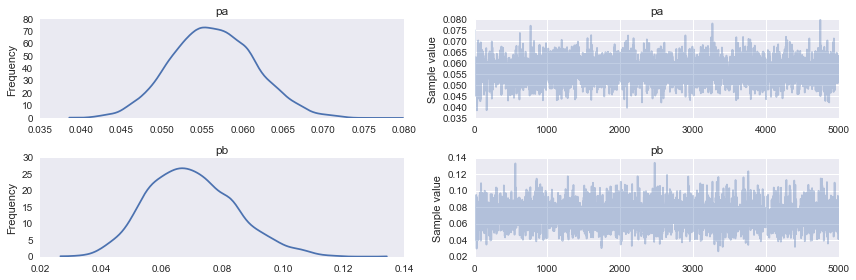

In [4]:
pm.traceplot(trace);

Visual inspection is a good start, but there a number of ways to assess convergence. Unfortunately there are no universal rules, [here](https://pymc-devs.github.io/pymc/modelchecking.html#autocorrelation-plots) is a good discussion of these problems, although note the examples are written for PyMC2 which has slightly different syntax (also note that PyMC2 and PyMC3 doesn't refer to Python 2 and 3, PyMC3 is a significant refactor of PyMC2).

Another good way to assess convergence is to look at autocorrelations in a chain. The autocorrelation should drop off over longer lags, as it does in this case quite dramatically.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116e79d30>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x1171be9b0>]], dtype=object)

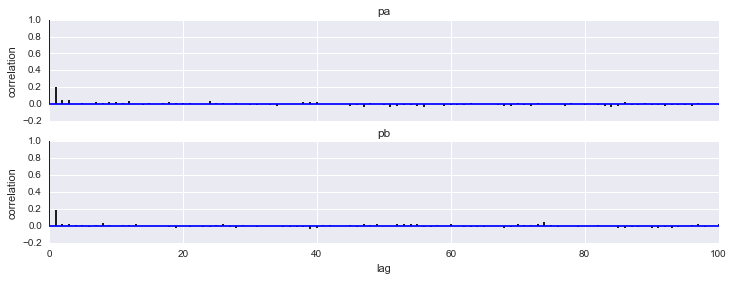

In [5]:
pm.autocorrplot(trace)

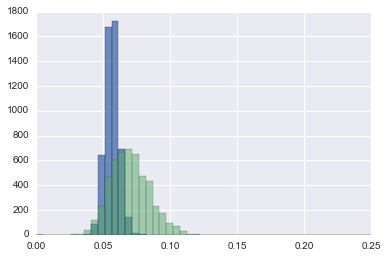

In [6]:
plt.hist(trace['pa'],bins=np.linspace(0,0.25,50),alpha=0.8);
plt.hist(trace['pb'],bins=np.linspace(0,0.25,50),alpha=0.5);

The trace is a random set of experiments in which the probability matched the observed data. Because the order is random, they can be directly compared to determine how often the conversion probability for B is greater than A.

In [7]:
print("The probability version B is better than version A is %0.2f" % (sum(trace['pb']>trace['pa'])/len(trace)))

The probability version B is better than version A is 0.81


This comparison works in this case because a Binomial distribution is described by a single parameter, the probability of conversion, so the mean and variance are both specified by the same measure. For other distributions, for example a Gaussian, differences in mean and variance can be important in deciding which is "better" from a business perspective. Furthermore, this doesn't give a sense for how much better B is. One way to assess that is to look at the histogram of the difference.

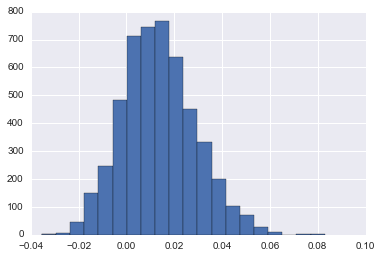

In [8]:
plt.hist((trace['pb'] - trace['pa']),bins=20);

In comparison, a frequentist approach would involve calculating a test statistic to evaluate the null hypothesis. For this case, our null hypothesis is that the probability of conversion for A and B is equal. A good introduction to hypothesis testing can be found [here](http://multithreaded.stitchfix.com/blog/2015/05/26/significant-sample/).

In [9]:
p = (na_obs+nb_obs)/(na+nb)
pa = na_obs/na
pb = nb_obs/nb
Z = (pa-pb)/np.sqrt(p*(1-p)*(1/na+1/nb))
pval = 2*(1 - st.norm.cdf(abs(Z)))
pval

0.45886572173307161

If we set our rejection threshold to a typical value, such as 0.05, we cannot reject the null hypthesis that the probability of conversion for A and B is equal. Of course there are many other statistical tests that can be done and may be more useful in certain circumstances. Futhermore, p-values are not particularly intuitive, because it isn't an actual probability of the hypothesis, while Bayesian inference does compute probabilities and is a little more straightforward to understand.

### Online Learning

Finally, we can do online learning by introducing new data in a very straightforward way. After our first experiment, we have an estimated distribution for the conversion probability. Instead of using a Uniform distribution for the prior as we did before we had any knowledge, we can pass this existing information onto the next simulation by making the prior match the estimated parameters. In this case we use a Beta distribution with the mean and standard deviation specified by the simulated data from the first experiment.

In [10]:
new_observed_a = gen_data(1000,60)
new_observed_b = gen_data(100,5)
with pm.model.Model():
    new_pa = pm.distributions.Beta('new_pa',mu=np.mean(trace['pa']),sd=np.std(trace['pa']))
    new_obs_a = pm.distributions.Bernoulli('new_obs_a',new_pa,observed=new_observed_a)
    new_pb = pm.distributions.Beta('new_pb',mu=np.mean(trace['pb']),sd=np.std(trace['pb']))
    new_obs_b = pm.distributions.Bernoulli('new_obs_b',new_pb,observed=new_observed_b)
    trace_new = pm.sample(5000)

/Users/BenRegner/Library/Python/3.5/lib/python/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -247.5: 100%|██████████| 200000/200000 [00:58<00:00, 3420.48it/s]
Finished [100%]: Average ELBO = -247.51
100%|██████████| 5000/5000 [00:12<00:00, 386.28it/s]


Our distributions become narrower (darker colors) as we get more data and a better sense of the true probabilities.

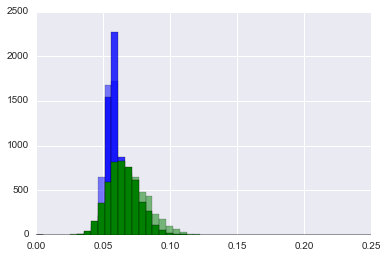

In [11]:
plt.hist(trace['pa'],bins=np.linspace(0,0.25,50),color='blue',alpha=0.5);
plt.hist(trace['pb'],bins=np.linspace(0,0.25,50),color='green',alpha=0.5);
plt.hist(trace_new['new_pa'],bins=np.linspace(0,0.25,50),color='blue',alpha=0.8);
plt.hist(trace_new['new_pb'],bins=np.linspace(0,0.25,50),color='green',alpha=1.);

In [12]:
print("The probability version B is better than version A is %0.2f" % (sum(trace_new['new_pb'][1000:]>trace_new['new_pa'][1000:])/len(trace_new[1000:])))

The probability version B is better than version A is 0.72


### Choosing Models and Priors (from FFL report)

*Probability distributions*

Probability distributions are the building blocks of probabilistic programming. They are used to define the generative model, and to place priors on coefficients. Here are a few examples with common use cases.

Generative models:
* Bernoulli/binomial — Events with two outcomes
* Categorical/multinomial — Events with several outcomes
* Poisson — Discrete events (e.g., website visitors, hardware failures)
* Normal — Observations with noise (e.g., sensor data)

Priors:

* Beta — Probabilities in Bernoulli trials
* Dirichlet — Probabilities in categorical trials
* Lognormal — Prior on unknown parameters that must be positive (e.g., physical size)
* Cauchy — Prior on parameters of linear regression

For more recommendations see [this post](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) from the Stan repository.

### PyMC3 Documentation

The [documentation](http://pymc-devs.github.io/pymc3/getting_started.html) for PyMC3 has a lot of examples, some of which are listed below.

### Linear Regression (and other linear models)

As shown above, probabilistic programming has advantages for even simple problems. Although much of the power comes from more sophisticated models that can't be solved using classic techniques, there are also benefits to familiar techniues such as linear regression. Here is a nice blog post that uses fake data to introduce Bayesian linear regression and discuss the benefits.

[Bayesian Inference with PyMC3 - Part 1](http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/)

---

Generalized Linear Models are a topic in themselves, and definitely worth checking out if you aren't familiar to better understand linear models. GLMs are also a convenient way to quickly specify a Bayesian linear model, as shown in this blog post.

[The Inference Button: Bayesian GLMs made easy with PyMC3](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)

---

Dealing with outliers can be done many ways, but Bayesian linear regression offers an elegant one. Instead of assuming the underlying data is normally distributed, you can assume a Student T distribution, which has more mass in the tails. In this model, outliers are more likely, and therefore have less influence on the mean. Below is a blog post doing this using PyMC3.

[This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)

---

This post is an in depth look at a more complicated linear model using car emission data. It introduces L1 regularization using a Laplace prior for the coefficients, but note that this type of regularization, in comparison to non-Bayesian methods, has a [slightly different intpretation](http://www.cs.bham.ac.uk/~axk/laplace.pdf) and there are [better methods](https://www.lx.it.pt/~mtf/IEEE_TPAMI_2003.pdf) to get sparse coefficients.


[Bayesian Inference with PyMC3 - Part 2](http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/)


### Hierarchical Models

As discussed in the FFL report, hierarchical models are incredibly powerful and naturally fit in a probabilistic programming framework. Here is a good introduction that uses a classic data set measuring the levels of radon in homes across a geographical area.

[The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)

---

The FFL report included a discussion of NYC apartment prices and a demo platform to play with. That model was inspired by the blog post [A hierarchical model of Finnish apartment prices](http://ropengov.github.io/r/2015/06/11/apartment-prices/) and the code can be found [here](https://github.com/reaktor/Neliohinnat). The model is written using Stan and uses R, but there is also a python package for Stan.

---

Here is another in depth post from the same author as the linear regression notebook above. This uses the same emission dataset, but pools data based on make and model.

[Bayesian Inference with PyMC3 - Part 3](http://blog.applied.ai/bayesian-inference-with-pymc3-part-3/)

---

Bayesian hierarchical models offer an interesting way to analyze sports results. An interesting example using rugby game scores and PyMC3 can be found [here](https://pymc-devs.github.io/pymc3/notebooks/rugby_analytics.html). There is also a similar analysis using PyMC2 which goes into slightly more depth, and isn't too hard to translate, which can be found [here](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/).

---

Hierarchical models can have some subtle problems to debug. Below is one particularly interesting case, with some interesting discussion about Bayesian models in general.

[Why hierarchical models are awesome, tricky, and Bayesian](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/)


### Fancy New Stuff

A cutting edge application of probabilistic programming is specifying neural network weights using a prior. There are many possible benefits, particularly in having more information about the uncertainty of a prediction. Here is a notebook that uses Normally distributed priors and connects them using the [Lasagne](https://github.com/Lasagne/Lasagne) package, with a Binomial likelihood to do binary classification. This could be a really interesting direction to go with a project, but be aware its relatively understudied and there will be challenges.

[Bayesian Deep Learning](https://gist.github.com/anonymous/96b998304de1eb4306738543170788ca)

---

A non-stationary timeseries can be modeled using a random walk process as a prior. This is fairly sophisticated material, but looks like it might be a really interesting way to handle classification of data with time dependence. It builds off the prevoius Deep Learning notebook so start there.

[Random-Walk Bayesian Deep Networks: Dealing with Non-Stationary Data](http://twiecki.github.io/blog/2017/03/14/random-walk-deep-net/)

---

Facebook recently released a time series prediction package called Prophet. The model is implemented in Stan, but is relatively straightforward.

[prophet/python/stan/unix at master · facebookincubator/prophet · GitHub](https://github.com/facebookincubator/prophet/tree/master/python/stan/unix)


## Books

**Bayesian Methods for Hackers** by Cameron Davidson-Pilon

Github repo is [here](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) and has version for both PyMC2 and PyMC3.

**Doing Bayesian Data Analysis** by John K. Kruschke (also known as the "puppy book" due to the cover art)

[Here](https://github.com/aloctavodia/Doing_bayesian_data_analysis) is a repo that implements all the examples in PyMC3

**Bayesian Data Analysis** by Andrew Gelman et al.

[This](http://bacbuc.hd.free.fr/WebDAV/data/Bouquins/Gelman%20-%20Bayesian%20Data%20Analysis.pdf) is long, but in depth and is considered the ultimate resource in the field.